In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import densenet121
from torchvision.models import swin_v2_s
from torchmetrics import AUROC
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchmetrics
import pytorch_lightning as pl
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
# torch.cuda.init()
# assert torch.cuda.is_initialized()
# print(torch.cuda.get_device_properties(0))
BRCA_ROOT = Path().home() / "datasets" / "brca-psj-path"
CONTEST_DIR = BRCA_ROOT / "contest-phase-2"
IMAGE_ROOT = CONTEST_DIR / "png-downsampled-train"
TABLE_DIR = CONTEST_DIR / "csv-train"
LOGGER_DIR = Path().home() / "logs"
torch.cuda.empty_cache()

2023-05-12 08:15:50.932477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 08:15:51.953702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
TEST_IMAGE_ROOT = CONTEST_DIR / "png-downsampled-holdout"
TEST_TABLE_DIR = CONTEST_DIR / "csv-train"
TEST_LOGGER_DIR = Path().home() / "logs"

In [3]:
# goal: create slide_id : cancer stage mapping
slide_biop_df = pd.read_csv(CONTEST_DIR / "slide-manifest-train.csv")
outcomes_df = pd.read_csv(TABLE_DIR / "outcomes.csv")
slide_stage_df = slide_biop_df.merge(outcomes_df, on="biopsy_id")
auroc = AUROC(task="multiclass", num_classes=5)
test_slide_biop_df = pd.read_csv(CONTEST_DIR / "slide-manifest-holdout.csv")


# map cancer stage to 0 - 4:
# outcomes_df["stage"].unique()
#     ['IA', 'IIB', 'IIA', '0', nan, 'IIIC', 'IV', 'IIIA', 'IIIB', 'IB']
def stage_to_int(stage):
    if stage == "0":
        return 0
    elif stage == "IA" or stage == "IB":
        return 1
    elif stage == "IIA" or stage == "IIB":
        return 2
    elif stage == "IIIA" or stage == "IIIB" or stage == "IIIC":
        return 3
    elif stage == "IV":
        return 4
    else:
        return np.nan


slide_stage_df["stage"] = slide_stage_df["stage"].apply(stage_to_int)

# subset columns, drop nans, reset index
labels_df = (
    slide_stage_df[["slide_id", "biopsy_id", "stage"]]
    .copy()
    .dropna(how="any")
    .reset_index(drop=True)
)
labels_df["stage"] = labels_df["stage"].astype(int)

labels_df.head(5)

,slide_id,biopsy_id,stage
0,028ad74f-ebd7-45e5-92da-b0f2ded35fdf,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2
1,0d677646-f6f8-4303-9c2c-4e7a39d8fdbb,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2
2,4716c9f5-1eba-444a-9658-39c0cab80f05,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2
3,6d9c5580-246b-4c29-a61f-674a2c07a556,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2
4,7787542f-9bea-419b-b3fd-84de67ddc42e,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2


In [4]:
test_slide_biop_df.head()

,slide_id,biopsy_id,patient_ngsci_id,slide_path
0,057870ad-2bec-4efc-bf03-da420fff33cd,4a78bef1-871d-4d4c-8dc4-fa8694c45de8,c9e6de10-73f6-4c95-a793-83ab9abd9dbe,/home/ngsci/datasets/brca-psj-path/ndpi-holdou...
1,1d662b36-aa75-402c-91c4-4149d9132c07,4a78bef1-871d-4d4c-8dc4-fa8694c45de8,c9e6de10-73f6-4c95-a793-83ab9abd9dbe,/home/ngsci/datasets/brca-psj-path/ndpi-holdou...
2,1f7c1ce3-18eb-4b49-a7a9-22fcb461f7ec,4a78bef1-871d-4d4c-8dc4-fa8694c45de8,c9e6de10-73f6-4c95-a793-83ab9abd9dbe,/home/ngsci/datasets/brca-psj-path/ndpi-holdou...
3,207329e7-dde2-4d7c-8289-2c96510479dd,4a78bef1-871d-4d4c-8dc4-fa8694c45de8,c9e6de10-73f6-4c95-a793-83ab9abd9dbe,/home/ngsci/datasets/brca-psj-path/ndpi-holdou...
4,241850c9-4526-4498-96ad-0998a67700db,4a78bef1-871d-4d4c-8dc4-fa8694c45de8,c9e6de10-73f6-4c95-a793-83ab9abd9dbe,/home/ngsci/datasets/brca-psj-path/ndpi-holdou...


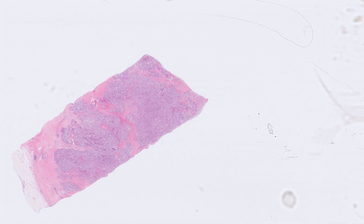

In [5]:
# split train and test set
def random_split(df, val_size):
    """helper function to split training and test sets"""
    n = len(df)
    idxs = np.random.randint(0, n, size=val_size)
    test_df = df.iloc[idxs].copy().reset_index(drop=True)
    train_df = df.drop(index=idxs).reset_index(drop=True)

    return train_df, test_df


train_df, test_df = random_split(labels_df, 1000)


# inspect image
def get_image(idx, df, numpy=False, to_float=False):
    """helper function to fetch image from disk"""
    path = os.path.join(IMAGE_ROOT, df.loc[idx, "slide_id"] + ".png")
    assert os.path.exists(path)

    img = Image.open(path)
    if numpy:
        arr = np.asarray(img)
        if to_float:
            arr = arr / 255.0
        return arr
    else:
        return img

    
def get_test_image(idx, df, numpy=False, to_float=False):
    """helper function to fetch image from disk"""
    path = os.path.join(TEST_IMAGE_ROOT, df.loc[idx, "slide_id"] + ".png")
    assert os.path.exists(path)

    img = Image.open(path)
    if numpy:
        arr = np.asarray(img)
        if to_float:
            arr = arr / 255.0
        return arr
    else:
        return img

    

img = get_image(7, train_df)
img

In [6]:
# compute means and stds for normalization

means = []
stds = []
for idx in range(100):
    arr = get_image(idx, train_df, numpy=True, to_float=True)
    means.append(arr.mean(axis=(0, 1)))
    stds.append(arr.std(axis=(0, 1)))

MEANS = np.vstack(means).mean(axis=0)
STDS = np.vstack(stds).mean(axis=0)

print(MEANS, STDS)

[0.90342983 0.87635377 0.92521326] [0.0475996  0.09891382 0.06301419]


In [7]:
# PyTorch requires two things:
# 1. Dataset (wrapper around Pandas-style Dataframe):
#    a. implements __len__
#    b. implements __getitem__
#    c. returns *single tuple* of (image, label)
# 2. DataLoader (see below)


class BiopsyDataset(Dataset):
    """Implements two functions: __len__ and __getitem__"""

    def __init__(self, df, transform=None, train=True):
        self.df = df
        self.transform = transform
        self.train = train

        if self.train:
            self.train = self.df.sample(frac=1.0, ignore_index=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = get_image(idx, self.df, numpy=True, to_float=True)
        label = int(self.df.loc[idx, "stage"])

        if self.transform:
            img = self.transform(img)

        return img, label

class BiopsyTestDataset(Dataset):
    """Implements two functions: __len__ and __getitem__"""

    def __init__(self, df, transform=None, train=False):
        self.df = df
        self.transform = transform
        self.train = train

        if self.train:
            self.train = self.df.sample(frac=1.0, ignore_index=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = get_test_image(idx, self.df, numpy=True, to_float=True)
        label = self.df.loc[idx, "slide_id"]

        if self.transform:
            img = self.transform(img)

        return img, label

In [8]:
# Pytorch DataLoaders are created as methods in Lightning DataModule class:
# 1. train_dataloader returns DataLoader for training dataset
# 2. test_dataloader returns DataLoader for test dataset
# 3. Image transformation happens at the DataLoader level,
#       but called within Dataset (inherited from torch.Dataset)


class BiopsyDataModule(pl.LightningDataModule):
    """Returns training and test data from datasets in batches of given size"""

    def __init__(self, df, predict_df , batch_size=32, num_workers=8):
        super().__init__()
        self.full_df = df
        self.tbpredicted= predict_df
        self.batch_size = batch_size
        self.num_workers = num_workers

        # note transformations: cast to Tensor, Resize, Normalize
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((224, 224)),
                transforms.Normalize(MEANS, STDS),
            ]
        )

        self.setup()

    def setup(self, stage=None):
        if stage == "train" or stage == None:
            torch.manual_seed(42)
            self.train_df, self.test_df = random_split(self.full_df, 1000)
            # use 20% of training data for validation
            train_set_size = int(len(self.train_df) * 0.8)
            valid_set_size = len(self.train_df) - train_set_size

            # split the train set into two
            torch.manual_seed(42)
            self.train_df, self.valid_df = random_split(self.train_df, train_set_size)
        else:
            pass
        

    def train_dataloader(self):
        return DataLoader(
            BiopsyDataset(self.train_df, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            BiopsyDataset(self.test_df, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )
    
    def val_dataloader(self):
        return DataLoader(
            BiopsyDataset(self.valid_df, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )
    
    def predict_dataloader(self):
        return DataLoader(
            BiopsyTestDataset(self.tbpredicted, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

In [9]:
# class BiopsyTestDataModule(pl.LightningDataModule):
#     """Returns training and test data from datasets in batches of given size"""

#     def __init__(self, df, batch_size=32, num_workers=8):
#         super().__init__()
#         self.full_df = df
#         self.batch_size = batch_size
#         self.num_workers = num_workers

#         # note transformations: cast to Tensor, Resize, Normalize
#         self.transform = transforms.Compose(
#             [
#                 transforms.ToTensor(),
#                 transforms.Resize((224, 224)),
#                 transforms.Normalize(MEANS, STDS),
#             ]
#         )

#         self.setup()

#     def setup(self, stage=None):
#         pass

#     def test_dataloader(self):
#         return DataLoader(
#             BiopsyTestDataset(self.full_df, transform=self.transform),
#             batch_size=self.batch_size,
#             num_workers=self.num_workers,
#         )

In [10]:
# create LightningModule that defines network architecture:
# 1. Need forward, training_step, test_step, configure_optimizer methods


class BiopsyModel(pl.LightningModule):
    """Defines deep learning model (resnet) and implements forward,
    training_step, test_step, and configure_optimizers"""

    def __init__(self, learning_rate=1e-3, num_classes=5):
        super().__init__()

        self.lr = learning_rate
        self.num_classes = num_classes

        # self.net = densenet121(pretrained=False, num_classes=self.num_classes)
        self.net =swin_v2_s(pretrained=False, num_classes=self.num_classes)
        self.net.double()

        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.outputs=[]
        self.val_outputs=[]
        
        #self.train_auroc= AUROC(task="multiclass", num_classes=self.num_classes)
    def forward(self, X):
        return self.net.forward(X)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self.net.forward(imgs)
        train_loss = nn.functional.cross_entropy(logits, labels)
        
        preds = nn.functional.softmax(logits, dim=-1)  # compute softmax probabilities
        # preds = torch.unsqueeze(preds, dim=1)  # Add an extra dimension to preds
        # preds=preds.type(torch.DoubleTensor)
        
        # identifying number of correct predections in a given batch
        correct=torch.argmax(preds,dim=-1).eq(labels).sum().item()
 
        # identifying total number of labels in a given batch
        total=len(labels)
        
        arg_preds= torch.argmax(preds, dim=-1)
        
        auroc = torchmetrics.functional.auroc(preds, labels,task="multiclass", num_classes=5, average="macro")
        
        batch_dictionary={
            #REQUIRED: It ie required for us to return "loss"
            "loss": train_loss,
             
            #optional for batch logging purposes
            "train_auroc": auroc,
 
            # info to be used at epoch end 
            "correct": correct,
            "total": total
        }
        # self.log("train_loss", loss, prog_bar=True )
        # self.log("train_auroc", auroc)
        self.outputs.append(batch_dictionary)
        return batch_dictionary
    
    def on_train_epoch_end(self):
        #  the function is called after every epoch is completed
 
        # calculating average loss  
        avg_loss = torch.stack([x['loss'] for x in self.outputs]).mean()
        avg_auroc = torch.stack([x['train_auroc'] for x in self.outputs]).mean()
        
        # calculating correect and total predictions
        correct=sum([x["correct"] for  x in self.outputs])
        total=sum([x["total"] for  x in self.outputs])
 
        # creating log dictionary
        tensorboard_logs = {'loss': avg_loss,"Accuracy": correct/total}
 
        epoch_dictionary={
            # required
            'loss': avg_loss,
             
            #required
            'AUROC': avg_auroc,
            
            # for logging purposes
            'log': tensorboard_logs}
    
        self.log("train_loss", avg_loss, prog_bar=True )
        self.log("train_auroc", avg_auroc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self.net.forward(imgs)
        #loss = nn.functional.cross_entropy(logits, labels)

        preds = nn.functional.softmax(logits, dim=-1)  # compute softmax probabilities
        self.test_accuracy.update(preds, labels)
        #self.auroc.update(preds, labels)
        #self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        #self.log("test_auroc", self.auroc, prog_bar=True)
        
        # convert labels to one-hot encoding
        labels_one_hot = np.eye(self.num_classes)[labels.cpu().numpy()]

        # convert predictions to binary classification for each class
        preds_binary = np.zeros_like(labels_one_hot)
        for i in range(self.num_classes):
            preds_binary[:, i] = preds[:, i].cpu().numpy() == preds.max(dim=1)[0].cpu().numpy()

        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(self.num_classes):
            fpr[i], tpr[i], _ = roc_curve(labels_one_hot[:, i], preds_binary[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-averaged ROC curve and AUC
        fpr["micro"], tpr["micro"], _ = roc_curve(labels_one_hot.ravel(), preds_binary.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-averaged ROC curve and AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(self.num_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(self.num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= self.num_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Plot ROC curve
        fig, ax = plt.subplots()
        ax.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
        ax.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
        for i in range(self.num_classes):
            ax.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title('Receiver Operating Characteristic')
            ax.legend()

        plt.savefig('densenet_plot.png')
        # Log ROC curve
        self.logger.log_graph(fig, "roc_curve")
        #print("testing")
        
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self.net.forward(imgs)
        val_loss = nn.functional.nll_loss(logits, labels)

        preds = torch.softmax(logits, dim=-1)
        # preds = torch.unsqueeze(preds, dim=1)  # Add an extra dimension to preds
        # preds=preds.type(torch.DoubleTensor)
        # identifying number of correct predections in a given batch
        correct=torch.argmax(preds,dim=-1).eq(labels).sum().item()
        
        # identifying total number of labels in a given batch
        total=len(labels)
        
        arg_preds= torch.argmax(preds, dim=-1)
        
        auroc = torchmetrics.functional.auroc(preds, labels,task="multiclass", num_classes=5, average="macro")
        
        # self.log("val_loss", val_loss)
        # self.log("val_auroc", val_auroc)
        
        batch_dictionary={
            #REQUIRED: It ie required for us to return "loss"
            "loss": val_loss,
            
            #optional for batch logging purposes
            "valid_auroc": auroc,
 
            # info to be used at epoch end 
            "correct": correct,
            "total": total
        }
        # self.log("val_loss", val_loss, prog_bar=True )
        # self.log("val_auroc", val_auroc)
        self.val_outputs.append(batch_dictionary)
        return batch_dictionary
        
        
    def on_validation_epoch_end(self):
        #  the function is called after every epoch is completed
 
        # calculating average loss  
        val_loss = torch.stack([x['loss'] for x in self.val_outputs]).mean()
        val_auroc = torch.stack([x['valid_auroc'] for x in self.val_outputs]).mean()
        
        # calculating correect and total predictions
        correct=sum([x["correct"] for  x in self.val_outputs])
        total=sum([x["total"] for  x in self.val_outputs])
 
        # creating log dictionary
        tensorboard_logs = {'loss': val_loss,"Accuracy": correct/total}
 
        epoch_dictionary={
            # required
            'loss': val_loss,
             
            #required
            'AUROC': val_auroc,
            
            # for logging purposes
            'log': tensorboard_logs}
    
        self.log("val_loss", val_loss, prog_bar=True )
        self.log("val_auroc", val_auroc)

    def predict_step(self, batch, batch_idx):
        imgs,labels = batch
        logits = self.net.forward(imgs)
        #loss = nn.functional.nll_loss(logits, labels)

        preds = torch.softmax(logits, dim=-1)
        arg_preds= torch.argmax(preds, dim=-1)
        #print(preds)
        return labels, preds, arg_preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [11]:
torch.manual_seed(42)
train_set, test_set = random_split(labels_df, 1000)
# use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

# split the train set into two
torch.manual_seed(42)
train_set, val_set = random_split(train_set, valid_set_size)
thistransform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((224, 224)),
                transforms.Normalize(MEANS, STDS),
            ]
        )

train_loader= DataLoader(
            BiopsyDataset(train_set, transform=thistransform),
            batch_size=32,
            num_workers=8,
        )
val_loader= DataLoader(
            BiopsyDataset(val_set, transform=thistransform),
            batch_size=32,
            num_workers=8,
        )

In [12]:
# The easy part! Train our model.
# Pytorch Lightning saves logs and parameters in specified directory
# note: change LOGGER_DIR at the top to change location of logs
torch.cuda.empty_cache()
data = BiopsyDataModule(labels_df,test_slide_biop_df)
model = BiopsyModel()
#model = torch.load(LOGGER_DIR/"biopsy_demo"/"version_0"/"checkpoints"/"epoch=49-step=3900.ckpt")
logger = pl.loggers.CSVLogger(save_dir=LOGGER_DIR, name="biopsy_demo")

# note: change max steps and epochs! (step = 1 step of gradient descent, i.e. one batch; epoch = 1 pass over entire dataset)
# accelerator="auto" will utilize a gpu if it is available

early_stopping = EarlyStopping(
    monitor="val_auroc", min_delta=0.005,
    patience=10,
)
callbacks=[early_stopping,ModelCheckpoint(save_top_k=5, mode="max",monitor="val_auroc",save_last=True)]

trainer = pl.Trainer(
    callbacks=callbacks,accelerator="auto", devices=4, max_epochs=50, logger=logger, log_every_n_steps=79, default_root_dir="logs/biopsy_demo/version_1/checkpoints/epoch=10-step=385.ckpt"
)


# trainer = pl.Trainer(
#     callbacks=callbacks,accelerator="auto", devices=1, max_steps=10, max_epochs=1, logger=logger
# )

# train model on training data
trainer.fit(model, train_loader, val_loader)







/opt/venv/default/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/venv/default/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distribu

Sanity Checking: 0it [00:00, ?it/s]

/opt/venv/default/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/opt/venv/default/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/opt/venv/default/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/opt/venv/default/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/venv/default/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/venv/default/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('train_auroc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/venv/default/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# test model on test data
trainer.test(model, data)

In [14]:
predictions = trainer.predict(model, data, ckpt_path="best")

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

Restoring states from the checkpoint path at /home/ngsci/logs/biopsy_demo/version_1/checkpoints/epoch=10-step=385.ckpt


ProcessExitedException: process 3 terminated with signal SIGSEGV

In [15]:
trainer2 = pl.Trainer(
    callbacks=callbacks,accelerator="auto", devices=2, max_epochs=50, logger=logger,
)
predictions = trainer2.predict(model, data)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

In [16]:
trainer3 = pl.Trainer(
    callbacks=callbacks,accelerator="auto", devices=2, max_epochs=50, logger=logger,
)
predictions = trainer3.predict(model, data)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

Restoring states from the checkpoint path at /home/ngsci/logs/biopsy_demo/version_4/checkpoints/epoch=6-step=245.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /home/ngsci/logs/biopsy_demo/version_4/checkpoints/epoch=6-step=245.ckpt


Testing: 0it [00:00, ?it/s]

/opt/venv/default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/opt/venv/default/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/venv/default/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/venv/default/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/ve

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4519999921321869
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4519999921321869}]

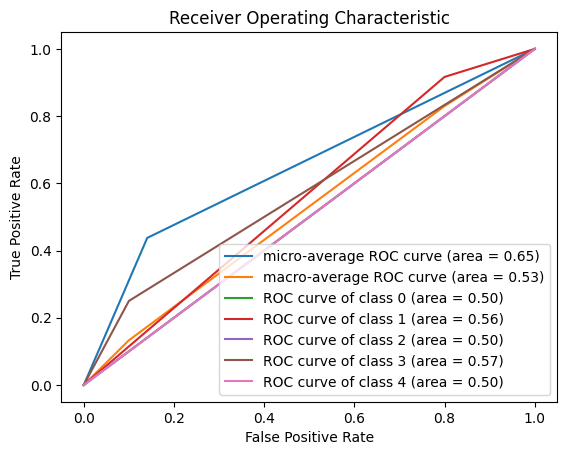

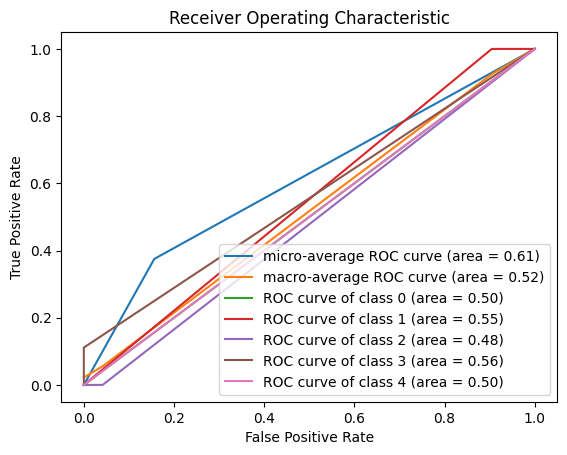

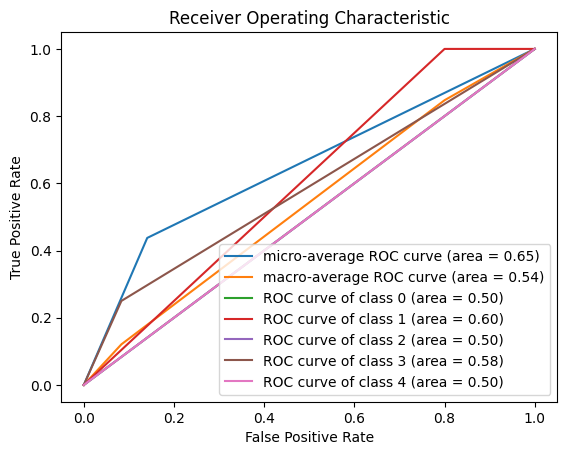

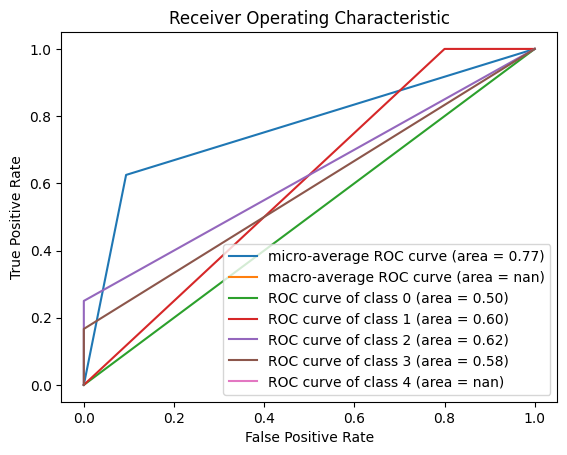

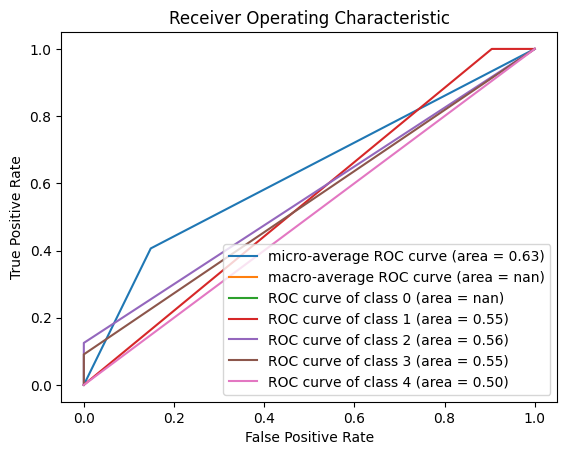

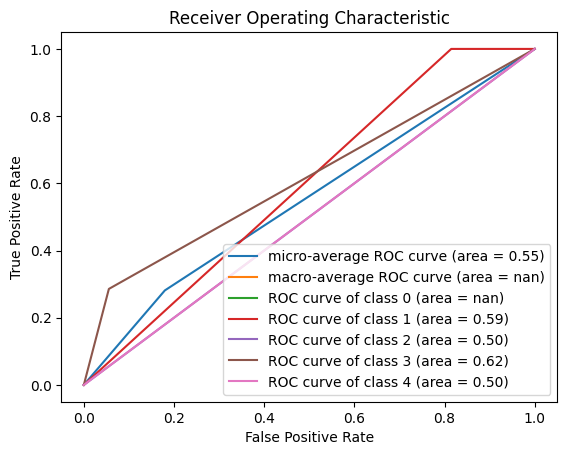

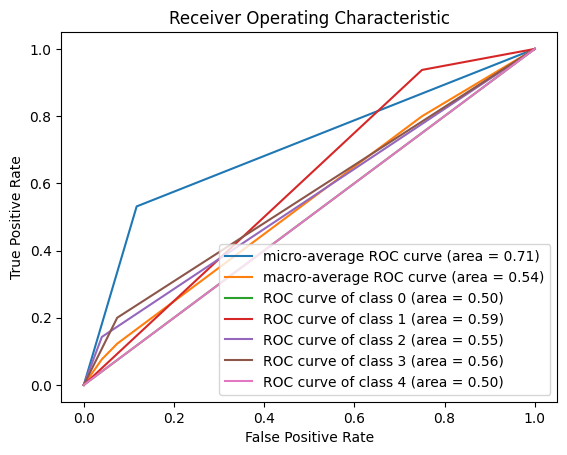

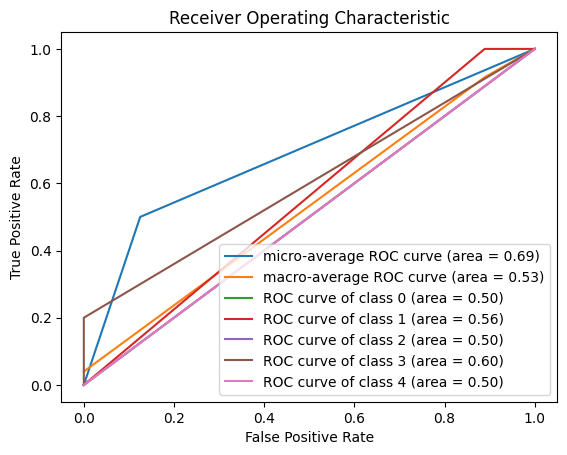

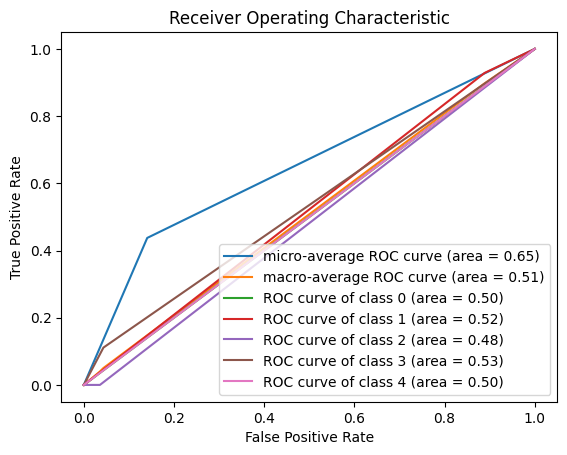

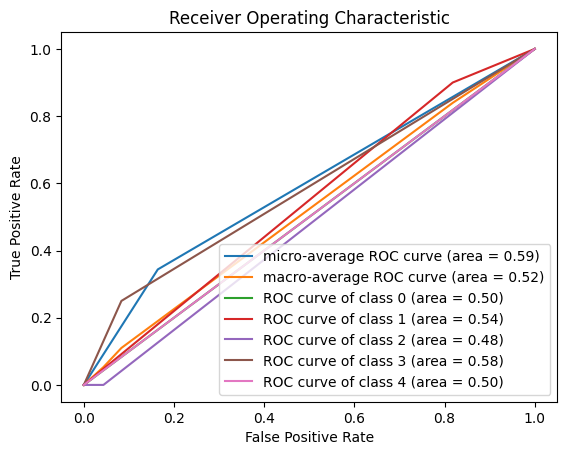

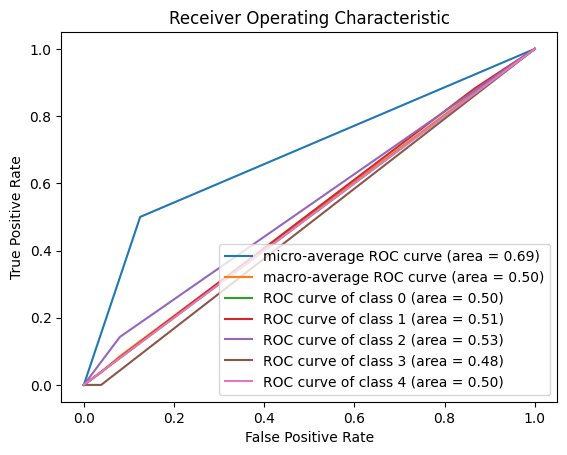

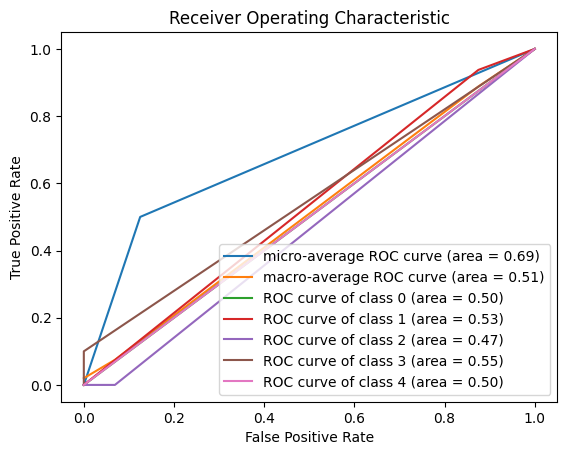

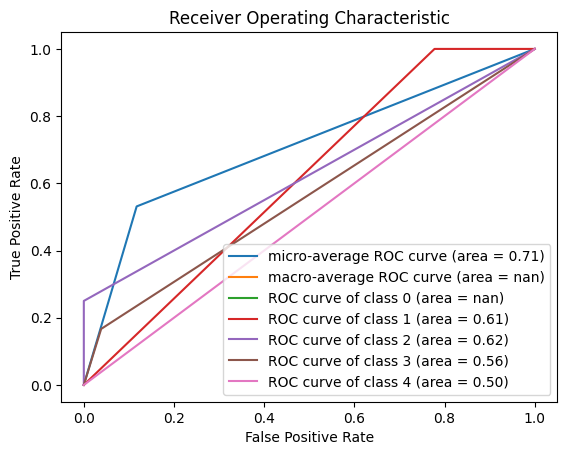

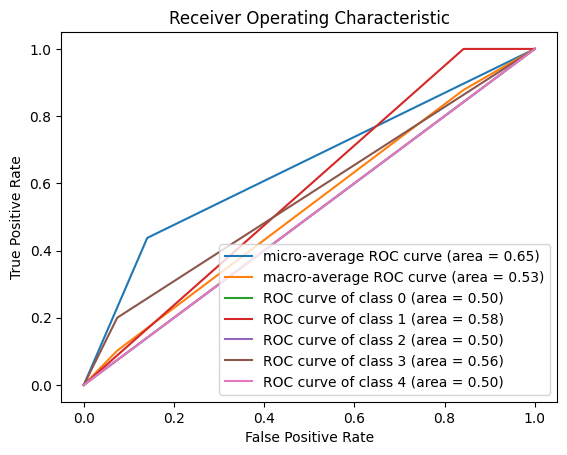

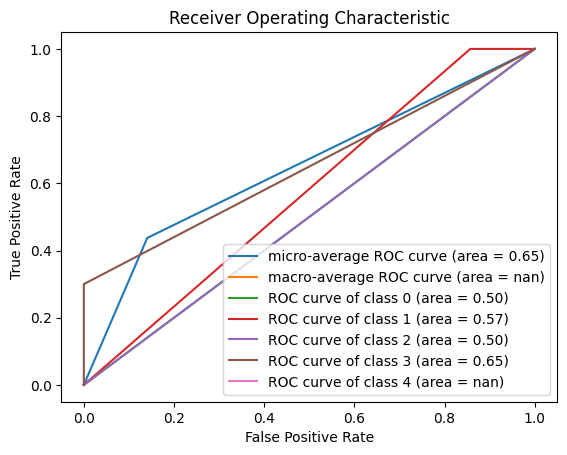

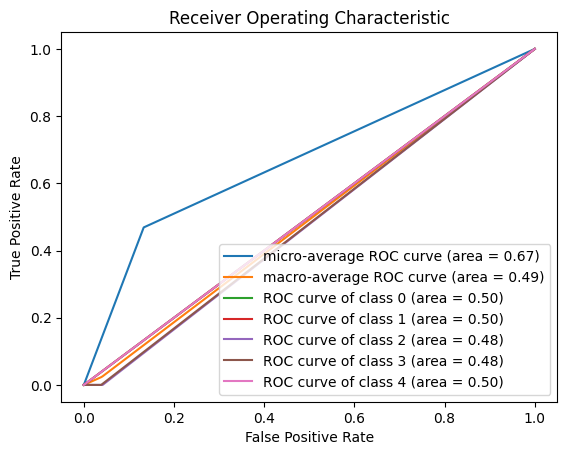

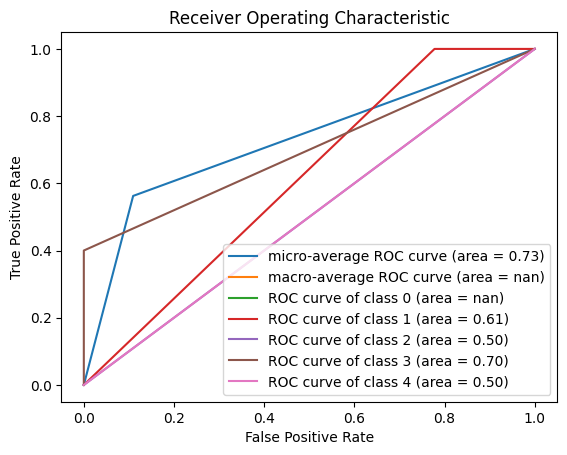

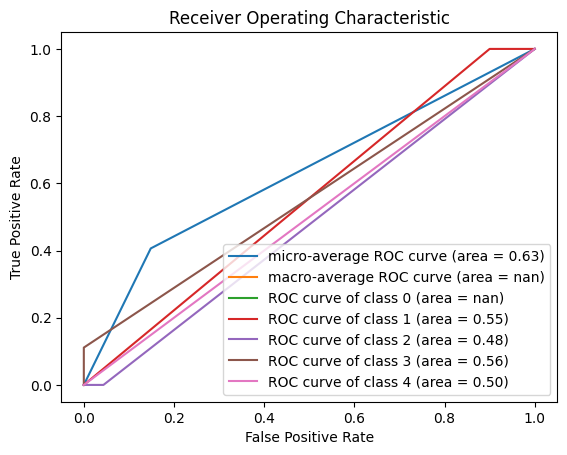

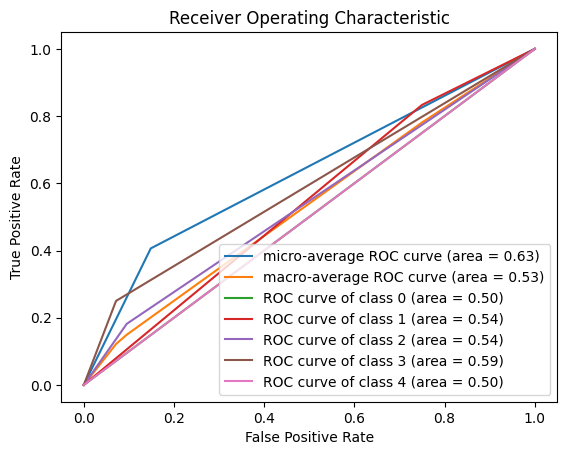

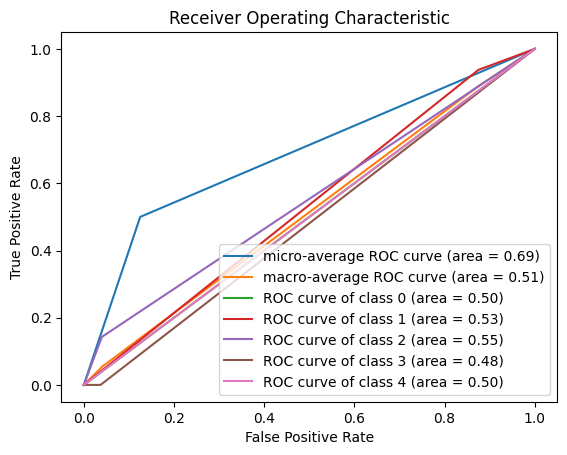

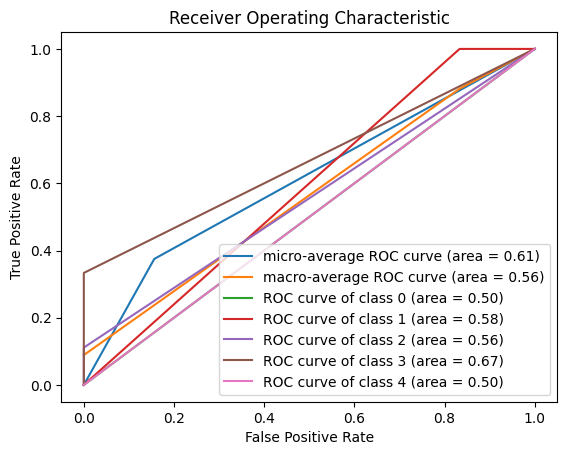

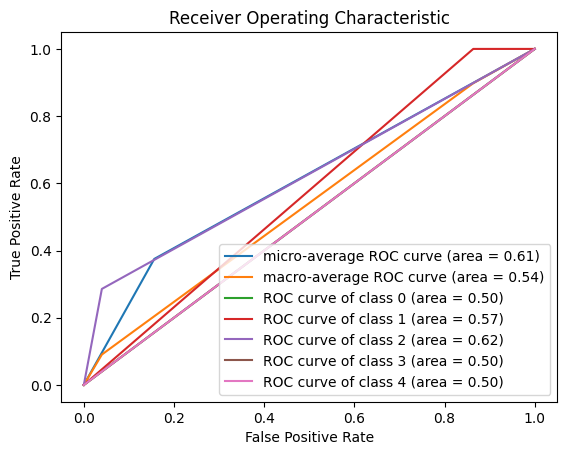

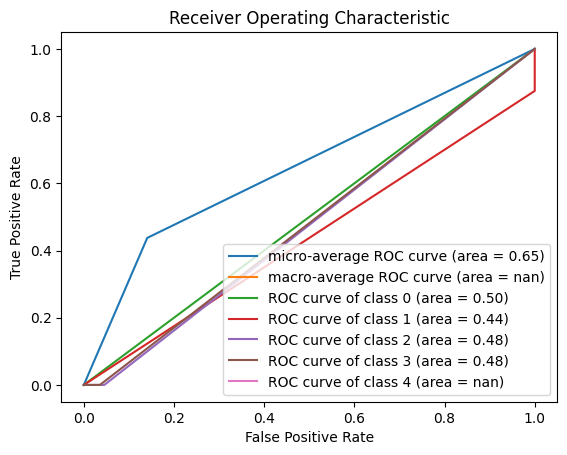

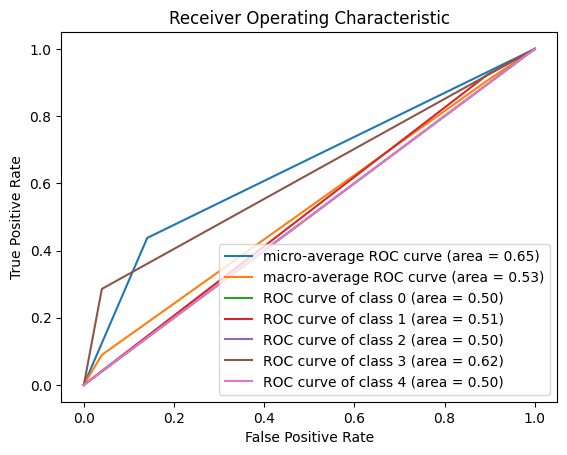

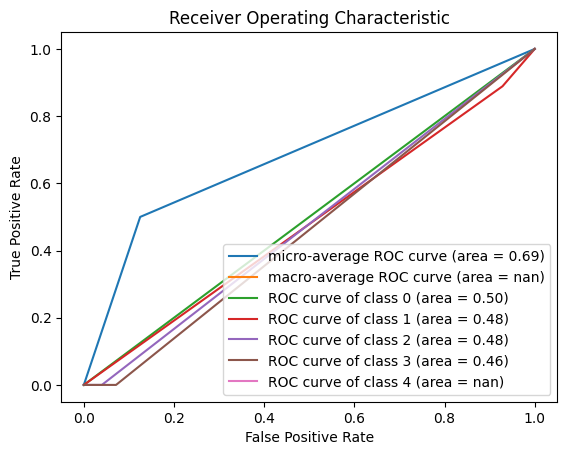

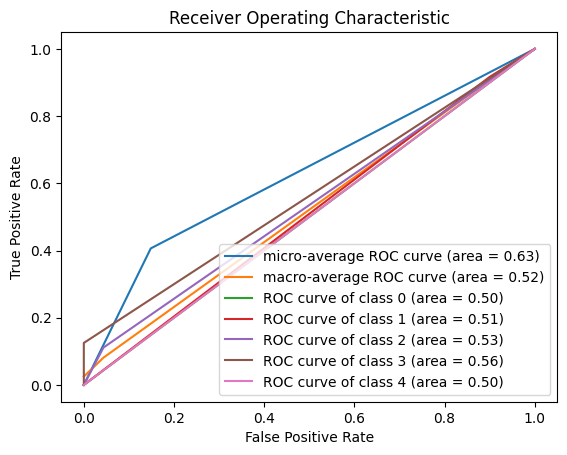

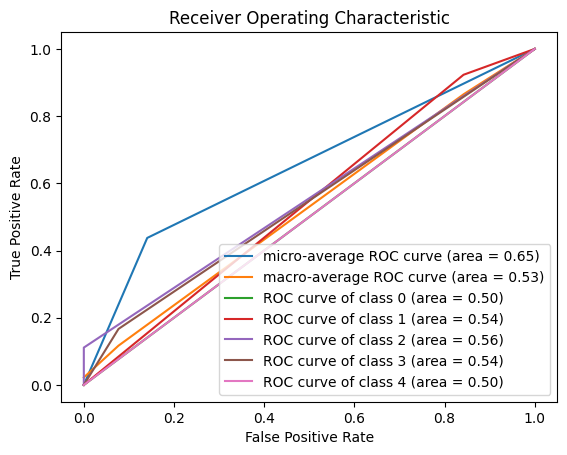

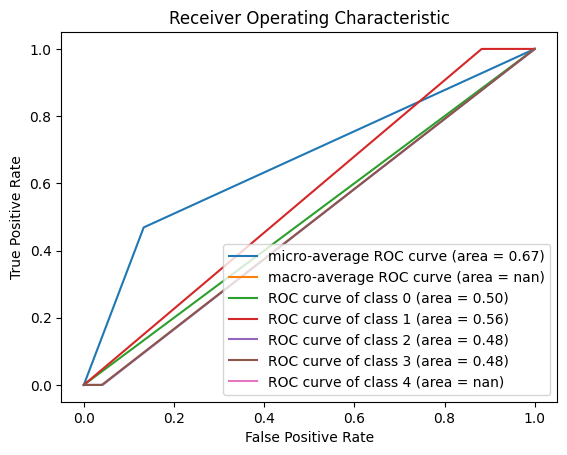

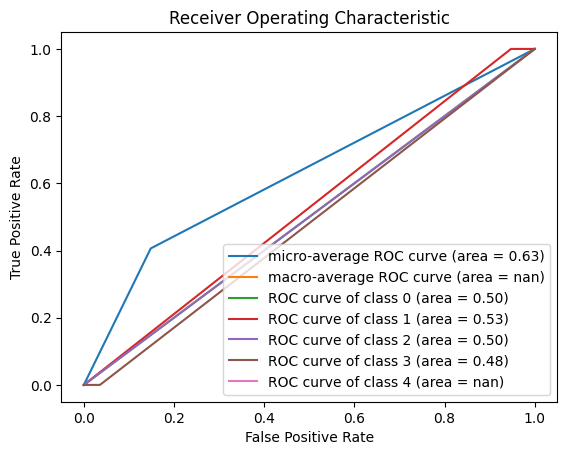

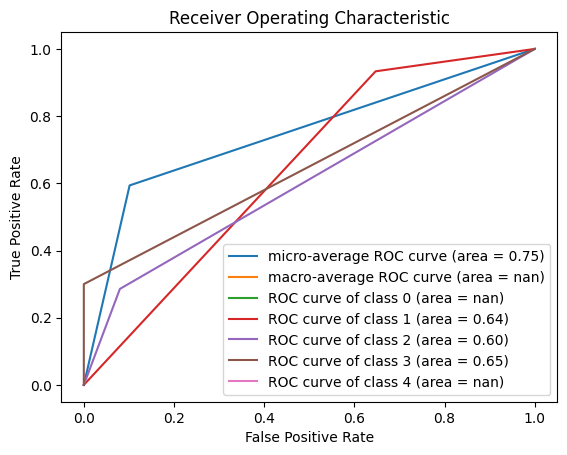

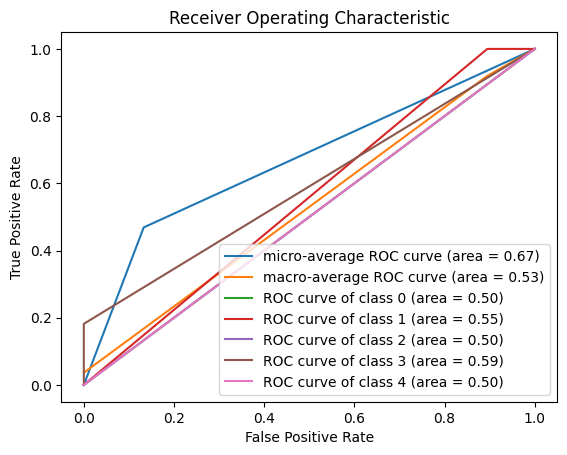

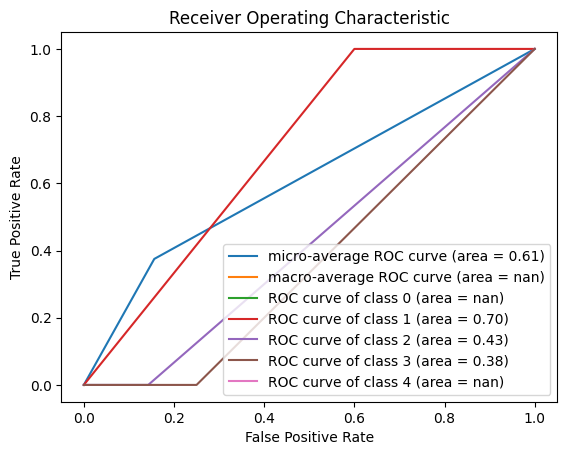

In [14]:
# test model on test data
trainer2.test(model, data, ckpt_path="best")

## Submission Pipeline

In [18]:
# slide_ids=None


# for i in range(len(predictions)):
#     if slide_ids is None:
#         slide_ids = np.asarray(predictions[i][0])
#     else:
#         #print(slide_ids.shape)
#         slide_ids = np.concatenate((slide_ids, predictions[i][0]))
#     #slide_ids.append(np.asarray(predictions[i][0]))
slide_ids=[]
for i in range(len(predictions)):
    slide_ids.append(np.asarray(predictions[i][0]))
slides=np.concatenate( slide_ids, axis=0 )
len(slides)

14466

In [19]:
soft_preds=[]
for i in range(len(predictions)):
    soft_preds.append(np.asarray(predictions[i][1]))
preds=np.concatenate( soft_preds, axis=0 )
print(preds.shape)

(14466, 5)


In [20]:
arg_preds=[]
for i in range(len(predictions)):
    arg_preds.append(np.asarray(predictions[i][2]))
final_preds=np.concatenate( arg_preds, axis=0 )
print(final_preds.shape)

(14466,)


In [21]:
#concats=np.concatenate((np.expand_dims(slides.expand_dims,1),preds,np.expand_dims(final_preds,1)))
slides=slides.reshape(-1,1)
#print(slides.shape)
final_preds=final_preds.reshape(-1,1)
#print(final_preds.shape)
concats=np.concatenate((slides,preds,final_preds),axis=1)

In [92]:
concats

array([['057870ad-2bec-4efc-bf03-da420fff33cd', '0.008446108795461375',
        '0.9915403545736493', ..., '5.721151295864677e-13',
        '5.884824243116522e-10', '1'],
       ['1d662b36-aa75-402c-91c4-4149d9132c07', '3.916047951724159e-23',
        '1.0', ..., '1.0436804672964295e-124', '4.5062085567361495e-99',
        '1'],
       ['1f7c1ce3-18eb-4b49-a7a9-22fcb461f7ec', '0.14037190568475652',
        '0.4127888650284618', ..., '0.05177113683430597',
        '0.1526929495135422', '1'],
       ...,
       ['ef13111b-8d43-439a-b028-1ada076cad40', '0.18435710562385585',
        '0.5985352820633707', ..., '0.021674589132797923',
        '0.06092806646463211', '1'],
       ['f048b7e3-95b4-4192-ab24-9f4cac467026', '0.1106079389277503',
        '0.4054650088267373', ..., '0.057136929175726325',
        '0.12339802360321232', '1'],
       ['ffbd8240-fe85-40f9-908d-95a005d9ec2c', '0.12536701247391743',
        '0.41513023772544694', ..., '0.05369192475383787',
        '0.14343486158098956'

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import ngsci

# get holdout directories
home = os.getenv("HOME")
contest_dir = os.path.join(home, "datasets", "brca-psj-path", "contest-phase-2")
subdf = pd.DataFrame(concats, columns = ['slide_id','prob_0','prob_1','prob_2','prob_3','prob_4','stage'])

subdf['prob_0']=subdf['prob_0'].astype(float)
subdf['prob_1']=subdf['prob_1'].astype(float)
subdf['prob_2']=subdf['prob_2'].astype(float)
subdf['prob_3']=subdf['prob_3'].astype(float)
subdf['prob_4']=subdf['prob_4'].astype(float)
subdf['stage']=subdf['stage'].astype(int)

slide_manifest= pd.read_csv(os.path.join(contest_dir, "slide-manifest-holdout.csv"))
#slide_manifest.agg(["count", "nunique"])
stage_predictions = (
    subdf
    .merge(slide_manifest, on='slide_id', how='outer')
     .drop(columns=['slide_id','slide_path','patient_ngsci_id'])
     .groupby("biopsy_id")
     .mean()
     .reset_index()
)
stage_predictions['stage']=stage_predictions['stage'].astype(int)
stage_predictions

,biopsy_id,prob_0,prob_1,prob_2,prob_3,prob_4,stage
0,0046d594-872b-47ce-bdea-b2853f249a4a,0.034414,0.536717,0.187711,0.167037,0.074121,1
1,0048fb50-689b-432d-acc6-9be1d30ddaba,0.133627,0.337922,0.398411,0.125522,0.004519,1
2,00acb063-63a1-4241-9a1a-a824c783782e,0.224064,0.369453,0.166981,0.089023,0.150479,1
3,00d0a1e5-0ee6-4a17-9ab1-7cf14faab778,0.002929,0.065339,0.154519,0.672237,0.104977,3
4,013d29dc-b4ed-48f5-985c-2793b3071d8c,0.062429,0.363653,0.238056,0.235104,0.100757,1
...,...,...,...,...,...,...,...
881,ff63f564-2b14-459f-b496-d429da8b4332,0.084982,0.411391,0.308797,0.182957,0.011873,1
882,ffbb2595-2c8d-4223-9f2a-91da1b4f02f4,0.020843,0.206984,0.138467,0.209268,0.424438,3
883,ffeda9d1-c7b2-4b6a-b8d2-4cd33d38fec2,0.068706,0.243072,0.376970,0.299468,0.011784,2
884,fff58b6e-656d-47bf-aa06-bf4efccd960c,0.044430,0.357425,0.315329,0.241853,0.040962,2


In [23]:
filepath = "~/project/densenet-submission.csv"

stage_predictions.to_csv(filepath, index=False, header=False)

In [24]:
ngsci.submit_contest_entry(
    "densenet-submission.csv", description="This is densenet submission"
)

(<Result.SUCCESS: 1>, 'Success')

## Loss Curves Plotted

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# load logs from CSV file
train_logs = pd.read_csv(str(LOGGER_DIR)+"/biopsy_demo/version_4/metrics.csv")
val_logs=train_logs.loc[:, train_logs.columns.drop(['train_loss', 'train_auroc'])]
val_logs=val_logs[val_logs['val_auroc'].notna()]
val_logs.head()

,val_loss,val_auroc,epoch,step
0,-0.771115,0.556329,0,63
2,-0.641304,0.556454,1,127
4,-0.845809,0.591743,2,191
6,-0.776311,0.581007,3,255
8,-0.747291,0.599329,4,319


In [16]:
train_logs = pd.read_csv(str(LOGGER_DIR)+"/biopsy_demo/version_4/metrics.csv")
trained_logs=train_logs.loc[:, train_logs.columns.drop(['val_loss', 'val_auroc'])]
trained_logs=trained_logs[trained_logs['train_auroc'].notna()]
trained_logs.head()

,epoch,step,train_loss,train_auroc
1,0,63,1.405239,0.561552
3,1,127,1.354047,0.601837
5,2,191,1.345484,0.631736
7,3,255,1.330348,0.632834
9,4,319,1.328876,0.641056


In [17]:
colorWheel = ['#c1272d', '#0000a7' ,'#eecc16', '#008176' , '#b3b3b3']
fig_styles = {
    'lw': 1.5,
    'markersize': 2.5,
    'marker': 'o',
    'linestyle': '-'
    }

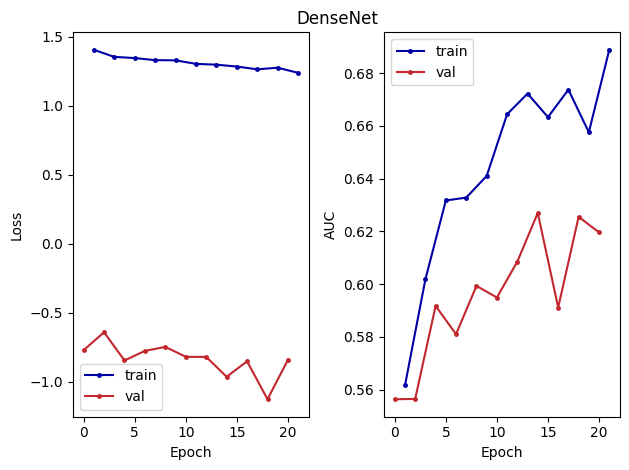

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2)
ax1=axs[0]
ax2=axs[1]
ax1.plot(trained_logs["train_loss"], label="train",color=colorWheel[1], **fig_styles )
ax1.plot(val_logs["val_loss"], label="val",color=colorWheel[0], **fig_styles)
ax2.plot(trained_logs["train_auroc"], label="train",color=colorWheel[1], **fig_styles )
ax2.plot(val_logs["val_auroc"], label="val",color=colorWheel[0], **fig_styles)
ax1.legend()
ax2.legend()
plt.title("DenseNet",x=-0.2)

# plt.title('DenseNet', y=0.98)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')

plt.tight_layout()

plt.show()

In [56]:
# inspect class distribution

data.test_df["stage"].value_counts().sort_index() / data.test_df["stage"].count()

0    0.080
1    0.388
2    0.235
3    0.236
4    0.061
Name: stage, dtype: float64

In [ ]:
fig.show()